# Import

In [25]:
import os
import mne
from mne import events_from_annotations, create_info, EpochsArray, concatenate_epochs, Epochs
import json
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt
import numpy as np
import warnings
from collections import defaultdict

warnings.filterwarnings("ignore", message=".*boundary.*data discontinuities.*")
warnings.filterwarnings("ignore", message="FigureCanvasAgg is non-interactive, and thus cannot be shown")

# Classes

### EEGTaskData

In [ ]:
class EEGTaskData:
    def __init__(self, subject, task, run, data_dir):
        self.subject = subject
        self.task = task
        self.run = run
        self.data_dir = data_dir

        self._raw = None
        self._filtered_cache = {}  # key = (l_freq, h_freq)
        self.metadata = {}
        self.events = None
        self.channels = None
        self.electrodes = None

        self._epochs_cache = {}  # key: (l_freq, h_freq) → (epochs, labels)

        self._load()


    def _get_file(self, ext, run=None):
        base = f"{self.subject}_task-{self.task}"
        if run:
            base += f"_run-{run}"
        file_name = f"{base}_{ext}"

        return self.data_dir / f"{self.subject}" / "eeg" / file_name

    def _load(self):
        eeg_path = self._get_file("eeg.set")
        self._raw = mne.io.read_raw_eeglab(eeg_path, preload=True, montage_units='cm')
        montage = mne.channels.make_standard_montage("GSN-HydroCel-128")
        self._raw.drop_channels(['Cz'])
        self._raw.set_montage(montage, match_case=False)
        # self._raw.filter(l_freq=self.l_freq, h_freq=self.h_freq)

        json_path = self._get_file("eeg.json")
        if json_path.exists():
            with open(json_path) as f:
                self.metadata = json.load(f)

        event_path = self._get_file("events.tsv")
        if event_path.exists():
            self.events = pd.read_csv(event_path, sep='\t')

        channels_path = self._get_file("channels.tsv")
        if channels_path.exists():
            self.channels = pd.read_csv(channels_path, sep='\t')

        electrodes_path = self._get_file("electrodes.tsv")
        if electrodes_path.exists():
            self.electrodes = pd.read_csv(electrodes_path, sep='\t')

    def get_filtered_raw(self, l_freq=1, h_freq=50):
        key = (l_freq, h_freq)
        
        # Return cached version if available
        if key in self._filtered_cache:
            return self._filtered_cache[key]
        
        if self._raw is None:
            return None

        # Filter and cache
        raw_copy = self._raw.copy().load_data()
        raw_copy.filter(l_freq=l_freq, h_freq=h_freq, fir_design="firwin", skip_by_annotation="edge")
        
        self._filtered_cache[key] = raw_copy
        return raw_copy

    def get_epochs(self, l_freq=1, h_freq=50):
        key = (l_freq, h_freq)
        if key in self._epochs_cache:
            return self._epochs_cache[key]

        if self.task == 'RestingState':
            epochs, labels = self._resting_preprocess(l_freq, h_freq)
        else:
            return None, None  # Unsupported task

        if epochs is not None:
            self._epochs_cache[key] = (epochs, labels)

        return epochs, labels

    def _resting_preprocess(self, tmin=0.0, tmax=20.0, l_freq=1, h_freq=50):
        """
        Crop raw based on 'resting_start' to 'break cnt' in events.tsv,
        then epoch using eye condition annotations.
        """
        filtered_raw = self.get_filtered_raw(l_freq=l_freq, h_freq=h_freq)

        # Step 1: Find resting_start and break cnt from TSV
        df = self.events

        t_start = df[df['value'] == 'resting_start']['onset'].values[0]
        t_end = df[df['value'] == 'break cnt']['onset'].values[1]

        # Step 2: Crop raw to this resting window
        filtered_raw.crop(tmin=t_start, tmax=t_end)

        # Step 3: Extract new events from cropped raw's annotations
        events, event_id = events_from_annotations(self._raw)

        eye_event_id = {
            'open': event_id['instructed_toOpenEyes'],
            'close': event_id['instructed_toCloseEyes']
        }

        # Step 4: Create epochs based on eye condition labels
        epochs = Epochs(
            filtered_raw,
            events=events,
            event_id=eye_event_id,
            tmin=tmin,
            tmax=tmax,
            proj=True,
            baseline=None,
            preload=True
        )

        labels = epochs.events[:, -1] - eye_event_id['open']  # 0=open, 1=close
        
        return epochs, labels

    def show_annotations(self):
        return self.metadata if self.metadata else None

    def show_table(self, name='events', rows=10, l_freq=1, h_freq=50):
        df_map = {
            'events': self.events,
            'channels': self.channels,
            'electrodes': self.electrodes
        }

        if name == 'epochs':
            epochs, labels = self.get_epochs(l_freq=l_freq, h_freq=h_freq)
            if epochs is None:
                return None

            info = {
                'n_epochs': len(epochs),
                'n_channels': len(epochs.ch_names),
                'timespan_sec': epochs.times[-1] - epochs.times[0],
                'labels': np.unique(labels) if labels is not None else 'N/A',
                'sampling_rate': epochs.info['sfreq'],
                'duration_per_epoch_sec': epochs.get_data().shape[-1] / epochs.info['sfreq']
            }
            return pd.DataFrame([info])

        df = df_map.get(name)
        return df.head(rows) if df is not None else None

    
    def get_raw(self):
        return self._raw



### EEGSubjectData

In [ ]:
class EEGSubjectData:
    def __init__(self, data_dir):
        self._data_dir = Path(data_dir)
        self._subject_ids = self._discover_subjects()
        self._task_index = self._discover_tasks()
        self._cache = {}  # (subj, task, run) → EEGTaskData

    def _discover_subjects(self):
        return sorted([p.name for p in self._data_dir.glob("sub-*") if p.is_dir()])

    def _discover_tasks(self):
        task_map = defaultdict(list)
        pattern = re.compile(
            r"(sub-(?P<subject>[^_]+))_task-(?P<task>[^_]+)(?:_run-(?P<run>\d+))?_eeg\.set"
        )

        for subj_dir in self._data_dir.glob("sub-*"):
            eeg_dir = subj_dir / "eeg"
            if not eeg_dir.exists():
                continue

            for eeg_file in eeg_dir.glob("sub-*_task-*_eeg.set"):
                match = pattern.match(eeg_file.name)
                if match:
                    full_subj = match.group(1) 
                    task = match.group("task")
                    run = match.group("run")
                    task_map[full_subj].append((task, run))

        return dict(task_map)

    def list_subjects(self):
        return self._subject_ids

    def list_tasks(self, subject):
        return sorted(self._task_index.get(subject, []))

    def get_task(self, subject, task, run=None):
        key = (subject, task, run)
        if key not in self._cache:
            task_data = EEGTaskData(
                subject=subject,
                task=task,
                run=run,
                data_dir=self._data_dir,
            )
            self._cache[key] = task_data
        return self._cache[key]

### EEGVisualization

In [28]:
class EEGVisualization:
    def __init__(self, subject_data: EEGSubjectData):
        self.data = subject_data

    def plot_sensors(self, subject, task, run=None, **kwargs):
        l_freq = kwargs.get("l_freq", 1)
        h_freq = kwargs.get("h_freq", 50)

        task_data = self.data.get_task(subject, task, run)
        raw = task_data.get_filtered_raw(l_freq, h_freq)
        raw.plot_sensors(show_names=True)

    def plot_time(self, subject, task, run=None, **kwargs):
        l_freq = kwargs.get("l_freq", 1)
        h_freq = kwargs.get("h_freq", 50)
        duration = kwargs.get('duration', 10.0)
        start = kwargs.get('start', 0.0)
        n_channels = kwargs.get('n_channels', 10)

        task_data = self.data.get_task(subject, task, run)
        raw = task_data.get_filtered_raw(l_freq, h_freq)

        title = f"{subject} - {task}" + (f" (Run {run})" if run else "")
        raw.plot(
            title=title,
            duration=duration,
            start=start,
            n_channels=n_channels,
            scalings='auto',
            show=True,
            block=True
        )

    def plot_frequency(self, subject, task, run=None, **kwargs):
        l_freq = kwargs.get("l_freq", 1)
        h_freq = kwargs.get("h_freq", 50)
        fmin = kwargs.get("fmin", 1)
        fmax = kwargs.get("fmax", 60)
        average = kwargs.get("average", True)
        dB = kwargs.get("dB", True)
        spatial_colors = kwargs.get("spatial_colors", False)
        show = kwargs.get("show", True)

        task_data = self.data.get_task(subject, task, run)
        raw = task_data.get_filtered_raw(l_freq, h_freq)

        psd = raw.compute_psd(fmin=fmin, fmax=fmax)
        psd.plot(average=average, spatial_colors=spatial_colors, dB=dB, show=show)

    def plot_conditionwise_psd(self, subject, task, run=None, **kwargs):
        fmin = kwargs.get("fmin", 1)
        fmax = kwargs.get("fmax", 50)
        tmin = kwargs.get("tmin", None)
        tmax = kwargs.get("tmax", None)
        average = kwargs.get("average", True)
        dB = kwargs.get("dB", True)

        l_freq = kwargs.get("l_freq", 1)
        h_freq = kwargs.get("h_freq", 50)

        task_data = self.data.get_task(subject, task, run)
        epochs, labels = task_data.get_epochs(l_freq=l_freq, h_freq=h_freq)
        if epochs is None:
            print(f"No epochs available for {subject} - {task}" + (f" (Run {run})" if run else ""))
            return
        event_ids = epochs.event_id

        for condition_name in event_ids:
            condition_epochs = epochs[condition_name]
            if tmin is not None or tmax is not None:
                condition_epochs = condition_epochs.copy().crop(tmin=tmin, tmax=tmax)

            psd = condition_epochs.compute_psd(fmin=fmin, fmax=fmax)
            psd.plot(spatial_colors=True, average=average, dB=dB)
            fig = plt.gcf()
            fig.suptitle(f"{subject} - {task} - {condition_name}", fontsize=14)
            fig.subplots_adjust(top=0.85)

            if tmin is not None or tmax is not None:
                caption = f"Epoch time window: tmin = {tmin if tmin is not None else 'auto'}, tmax = {tmax if tmax is not None else 'auto'}"
                fig.text(0.5, 0.01, caption, ha='center', fontsize=10)


### EEGController

In [29]:
class EEGController:
    def __init__(self, subject_data: 'EEGSubjectData', visualizer: 'EEGVisualization'):
        self.subject_data = subject_data
        self.visualizer = visualizer

    def list_subjects(self):
        return self.subject_data.list_subjects()

    def list_tasks(self, subject):
        return self.subject_data.list_tasks(subject)

    def show(self, subject, task, run=None, plot_type='time', **kwargs):
        if plot_type == 'time':
            self.visualizer.plot_time(subject, task, run, **kwargs)
        elif plot_type == 'sensors':
            self.visualizer.plot_sensors(subject, task, run)
        elif plot_type == 'frequency':
            self.visualizer.plot_frequency(subject, task, run)
        elif plot_type == 'conditionwise psd':
            self.visualizer.plot_conditionwise_psd(subject, task, run, **kwargs)

    def show_annotations(self, subject, task, run=None):
        """Return metadata dict or None."""
        task_data = self.subject_data.get_task(subject, task, run)
        return task_data.show_annotations() if task_data else None

    def show_table(self, subject, task, run=None, name='events', rows=10, l_freq=1, h_freq=50):
        """Return DataFrame or None."""
        task_data = self.subject_data.get_task(subject, task, run)
        return task_data.show_table(name=name, rows=rows, l_freq=l_freq, h_freq=h_freq)


    def get_annotation_df(self, subject, task, run=None):
        task_data = self.subject_data.get_task(subject, task, run)

        raw = task_data.get_filtered_raw()
        
        annots = raw.annotations
        df = pd.DataFrame({
            "onset": annots.onset,
            "duration": annots.duration,
            "description": annots.description
        })
        return df

### EEGUI

In [30]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import json 

class EEGUI:
    def __init__(self, controller: 'EEGController'):
        self.controller = controller

        # Get and sort subject list
        subjects = sorted(self.controller.list_subjects())

        # Widgets
        self.subject_dropdown = widgets.Dropdown(
            options=subjects,
            description='Subject:',
            layout=widgets.Layout(width='250px')
        )

        self.task_dropdown = widgets.Dropdown(
            options=[], 
            description='Task:',
            layout=widgets.Layout(width='250px')
        )

        self.run_text = widgets.Text(
            description='Run:',
            placeholder='Optional',
            layout=widgets.Layout(width='250px')
        )

        self.plot_type = widgets.ToggleButtons(
            options=['time', 'sensors', 'frequency', 'conditionwise psd'],
            description='Plot:',
            layout=widgets.Layout(width='600px')
        )

        self.lfreq_float = widgets.FloatText(
            value=1.0,
            description='l_freq:',
            layout=widgets.Layout(width='200px')
        )

        self.hfreq_float = widgets.FloatText(
            value=50.0,
            description='h_freq:',
            layout=widgets.Layout(width='200px')
        )


        # Frequency Domain
        self.average_check = widgets.Checkbox(
            value=True,
            description='Average',
            indent=False
        )

        self.db_check = widgets.Checkbox(
            value=True,
            description='dB',
            indent=False
        )

        # Time Domain
        self.duration_float = widgets.FloatText(value=10.0, description='duration:', layout=widgets.Layout(width='200px'))
        self.start_float = widgets.FloatText(value=0.0, description='start:', layout=widgets.Layout(width='200px'))
        self.nchan_int = widgets.IntText(value=10, description='n_channels:', layout=widgets.Layout(width='200px'))

        # Time and frequency inputs
        self.tmin_float = widgets.FloatText(value=0.0, description='tmin:', layout=widgets.Layout(width='200px'))
        self.tmax_float = widgets.FloatText(value=2.0, description='tmax:', layout=widgets.Layout(width='200px'))
        self.fmin_float = widgets.FloatText(value=1.0, description='fmin:', layout=widgets.Layout(width='200px'))
        self.fmax_float = widgets.FloatText(value=50.0, description='fmax:', layout=widgets.Layout(width='200px'))

        # Param containers
        self.filter_controls = widgets.HBox([self.lfreq_float, self.hfreq_float])
        self.t_controls = widgets.HBox([self.tmin_float, self.tmax_float])
        self.f_controls = widgets.HBox([self.fmin_float, self.fmax_float])
        self.time_controls = widgets.HBox([self.duration_float, self.start_float, self.nchan_int])
        self.psd_options = widgets.HBox([self.average_check, self.db_check])
        self.param_box = widgets.VBox([])

        self.plot_button = widgets.Button(description='Plot', button_style='success')

        self.table_type = widgets.Dropdown(
            options=['events', 'channels', 'electrodes', 'epochs'],
            description='Table:',
            layout=widgets.Layout(width='250px')
        )

        self.info_button = widgets.Button(description='Show Info', button_style='info')
        self.output = widgets.Output()

        # Link events
        self.subject_dropdown.observe(self.update_tasks, names='value')
        self.plot_type.observe(self.update_param_inputs, names='value')
        
        self.plot_button._click_handlers.callbacks.clear()
        self.plot_button.on_click(self.do_plot)

        self.info_button._click_handlers.callbacks.clear()
        self.info_button.on_click(self.do_show_info)

        # UI layout
        self.ui = widgets.VBox([
            self.subject_dropdown,
            self.task_dropdown,
            self.run_text,
            self.plot_type,
            self.param_box,
            self.plot_button,
            widgets.HBox([self.table_type, self.info_button]),
            self.output
        ])

        # Init values
        if subjects:
            self.subject_dropdown.value = subjects[0]
            self.update_tasks()
        self.update_param_inputs()  # Show/hide params based on default selection

    def update_tasks(self, *args):
        subject = self.subject_dropdown.value
        task_keys = sorted(self.controller.list_tasks(subject))
        formatted = [(f"{t} (run {r})" if r else t, (t, r)) for t, r in task_keys]
        self.task_dropdown.options = formatted
        if formatted:
            self.task_dropdown.value = formatted[0][1]

    def update_param_inputs(self, *args):
        if self.plot_type.value == 'conditionwise psd':
            self.param_box.children = [self.t_controls, self.f_controls, self.filter_controls, self.psd_options]
        elif self.plot_type.value == 'frequency':
            self.param_box.children = [self.f_controls, self.filter_controls, self.psd_options]
        elif self.plot_type.value == 'time':
            self.param_box.children = [self.time_controls, self.filter_controls]
        else:
            self.param_box.children = []

    def do_plot(self, _):
        with self.output:
            clear_output(wait=True)

            subject = self.subject_dropdown.value
            task_value = self.task_dropdown.value
            if task_value is None:
                print("No task selected.")
                return

            task, run = task_value
            run = run if run else None

            kwargs = {
                'tmin': self.tmin_float.value,
                'tmax': self.tmax_float.value,
                'fmin': self.fmin_float.value,
                'fmax': self.fmax_float.value,
                'l_freq': self.lfreq_float.value,
                'h_freq': self.hfreq_float.value,
                'duration': self.duration_float.value,
                'start': self.start_float.value,
                'n_channels': self.nchan_int.value,
                'average': self.average_check.value,
                'dB': self.db_check.value
            }

            self.controller.show(subject, task, run, plot_type=self.plot_type.value, **kwargs)

    def do_show_info(self, _):
        with self.output:
            clear_output(wait=True)

            subject = self.subject_dropdown.value
            task_value = self.task_dropdown.value
            if task_value is None:
                print("No task selected.")
                return

            task, run = task_value
            run = run if run else None

            # Get filter params
            l_freq = self.lfreq_float.value
            h_freq = self.hfreq_float.value

            # Show annotations
            metadata = self.controller.show_annotations(subject, task, run)
            print(f"Metadata for {subject} - {task}" + (f" (Run {run})" if run else "") + ":")
            print(json.dumps(metadata, indent=2) if metadata else "No metadata available.")

            # Show table
            table_name = self.table_type.value
            df = self.controller.show_table(subject, task, run, name=table_name, l_freq=l_freq, h_freq=h_freq)
            print(f"\nTable: {table_name}")
            if df is not None:
                display(df)
            else:
                print("No table data available.")

    def show(self):
        display(self.ui)

# Initialize

### Load

In [ ]:
load = 1
if load:
    data_dir = '/mount/NAS-public-dataset/HBN-EEG/cmi_bids_R1'
    subject_data = EEGSubjectData(data_dir)

### UI

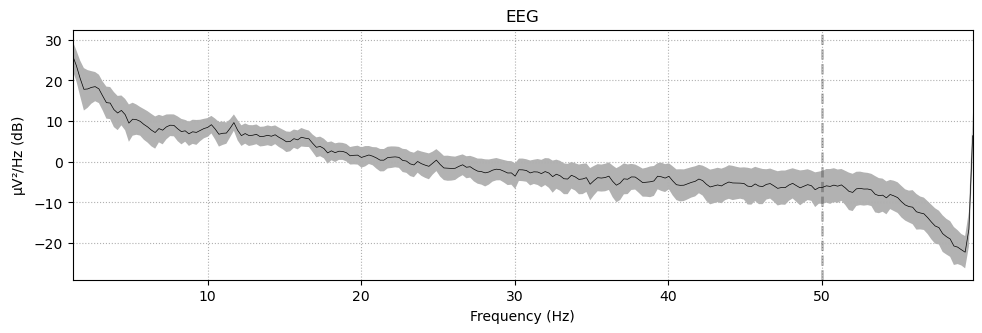

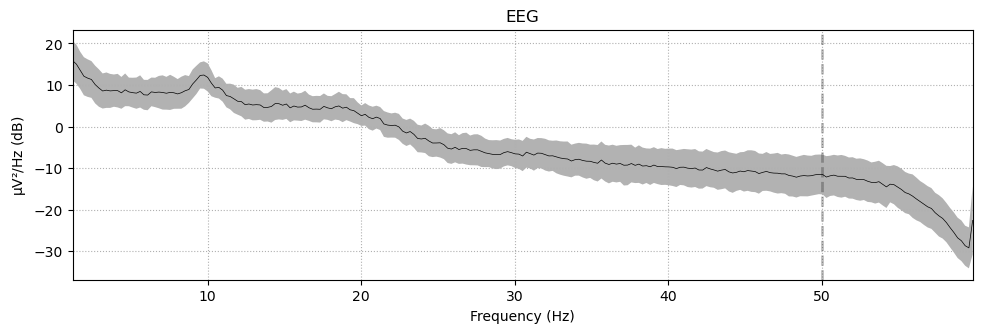

In [ ]:
%matplotlib inline

visualizer = EEGVisualization(subject_data)
controller = EEGController(subject_data, visualizer)

ui = EEGUI(controller)
ui.show()